In [1]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import gym 
import matplotlib.pyplot as plt

## Deep Q-Network

In [2]:
class DeepQNetwork(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims, 
            n_actions):
        super(DeepQNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        actions = self.fc3(x)

        return actions

## Agent-brain

In [3]:
class Agent():
    def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions,
            max_mem_size=100000, eps_end=0.05, eps_dec=5e-4):
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.lr = lr
        self.action_space = [i for i in range(n_actions)]
        self.mem_size = max_mem_size
        self.batch_size = batch_size
        self.mem_cntr = 0
        self.iter_cntr = 0
        self.replace_target = 100

        self.Q_eval = DeepQNetwork(lr, n_actions=n_actions, input_dims=input_dims,
                                    fc1_dims=256, fc2_dims=256)
        self.Q_next = DeepQNetwork(lr, n_actions=n_actions, input_dims=input_dims,
                                    fc1_dims=64, fc2_dims=64)

        self.state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)

    def store_transition(self, state, action, reward, state_, terminal):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = terminal

        self.mem_cntr += 1
        

    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            state = T.tensor([observation]).to(self.Q_eval.device)
            actions = self.Q_eval.forward(state)
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)

        return action
    
    

    def train(self):
        if self.mem_cntr < self.batch_size:
            return

        self.Q_eval.optimizer.zero_grad()
        
        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, self.batch_size, replace=False)
        
        batch_index = np.arange(self.batch_size, dtype=np.int32)

        state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
        new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
        action_batch = self.action_memory[batch]
        reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
        terminal_batch = T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)

        q_eval = self.Q_eval.forward(state_batch)[batch_index, action_batch]
        q_next = self.Q_eval.forward(new_state_batch)
        q_next[terminal_batch] = 0.0

        q_target = reward_batch + self.gamma*T.max(q_next,dim=1)[0]

        loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
        loss.backward()
        self.Q_eval.optimizer.step()

        self.iter_cntr += 1
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min \
                       else self.eps_min

## Main Loop for LunarLander-v2

In [4]:
env = gym.make('LunarLander-v2')
agent = Agent(gamma=0.99, epsilon=1.0, batch_size=64, n_actions=4, eps_end=0.01,
              input_dims=[8], lr=0.0003)
scores, eps_history, avg_score = [], [], []
n_games = 1200

avg_score=[]
for i in range(n_games):
    score = 0
    done = False
    observation = env.reset()
    while not done:
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        score += reward
        agent.store_transition(observation, action, reward, 
                                observation_, done)
        agent.train()
        observation = observation_
    scores.append(score)
    eps_history.append(agent.epsilon)

    running_avg_score = np.mean(scores[-100:])
    
    avg_score.append(running_avg_score)

    print('Episode ', i, 'Score %.2f' % score,
            'Running Average Score %.2f' % running_avg_score,
            'Epsilon %.2f' % agent.epsilon)
    

Episode  0 Score -170.60 Running Average Score -170.60 Epsilon 0.97
Episode  1 Score -98.78 Running Average Score -134.69 Epsilon 0.92
Episode  2 Score -96.04 Running Average Score -121.81 Epsilon 0.87
Episode  3 Score -97.22 Running Average Score -115.66 Epsilon 0.83
Episode  4 Score -84.71 Running Average Score -109.47 Epsilon 0.76
Episode  5 Score -197.07 Running Average Score -124.07 Epsilon 0.72
Episode  6 Score -140.82 Running Average Score -126.47 Epsilon 0.65
Episode  7 Score -96.36 Running Average Score -122.70 Epsilon 0.57
Episode  8 Score -84.73 Running Average Score -118.48 Epsilon 0.44
Episode  9 Score -153.84 Running Average Score -122.02 Epsilon 0.35
Episode  10 Score -32.99 Running Average Score -113.92 Epsilon 0.20
Episode  11 Score -101.25 Running Average Score -112.87 Epsilon 0.01
Episode  12 Score -240.18 Running Average Score -122.66 Epsilon 0.01
Episode  13 Score -150.39 Running Average Score -124.64 Epsilon 0.01
Episode  14 Score -88.00 Running Average Score -122

## Plot Avg. Rewards/Episodes

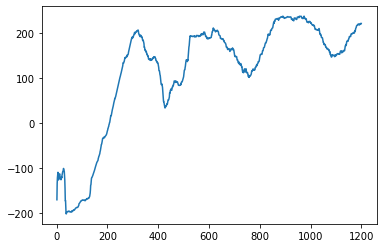

In [5]:
import seaborn as sns
x = [i+1 for i in range(n_games)]
sns.lineplot(x,avg_score)        

## Lunar Lander with Random Actions

In [6]:
env = gym.make('LunarLander-v2')
states = env.observation_space.shape[0]
actions = env.action_space.n

In [7]:
actions

4

In [8]:
states

8

In [9]:
import random
episodes = 100
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        env.render()
        action = random.choice([0,1])
        n_state, reward, done, info = env.step(action)
        score+=reward
    print('Episode:{} Score:{}'.format(episode, score))

Episode:1 Score:-257.6998458356918
Episode:2 Score:-532.8767050134657
Episode:3 Score:-433.8009221868806
Episode:4 Score:-353.1375499174392
Episode:5 Score:-372.97119098097073
Episode:6 Score:-416.13331955622203
Episode:7 Score:-415.3841082527633
Episode:8 Score:-227.30796189835064
Episode:9 Score:-232.8408233276816
Episode:10 Score:-196.68032688361
Episode:11 Score:-459.4299448212891
Episode:12 Score:-228.79793522856966
Episode:13 Score:-534.6986235499742
Episode:14 Score:-224.98454176263743
Episode:15 Score:-265.90914551077026
Episode:16 Score:-372.30631143736326
Episode:17 Score:-533.68786469159
Episode:18 Score:-511.542184392417
Episode:19 Score:-177.52757147868624
Episode:20 Score:-203.8543323474367
Episode:21 Score:-460.20400374324987
Episode:22 Score:-369.59584375074974
Episode:23 Score:-462.7748802869919
Episode:24 Score:-314.12375717716964
Episode:25 Score:-265.67303761936773
Episode:26 Score:-424.05103182986863
Episode:27 Score:-278.30157158349834
Episode:28 Score:-313.603639